# Load Data

In [53]:
import pandas as pd
import numpy as np
from operator import itemgetter
import itertools
import json
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from tkinter import filedialog as fd
from pandas.api.types import is_numeric_dtype
from matplotlib import pyplot as plt
import time

start=time.time()
filename = fd.askopenfilename()
df = pd.read_csv(filename, header=None ,on_bad_lines='skip')

# Data Preprocessing

### Handling NULL and NaN values

In [41]:
df.fillna(df.mean(), inplace=True)

C:\Users\villu\AppData\Local\Temp\ipykernel_12628\820435583.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.fillna(df.mean(), inplace=True)


### Data normalization using maximum absolute scaling

In [42]:
df_maximum_scaled = df.copy()
for j in df_maximum_scaled.columns:
    if is_numeric_dtype(j):
        df_maximum_scaled[j] = df_maximum_scaled[j] / df_maximum_scaled[j].abs().max()
df = df_maximum_scaled.copy()

### Handling same instances with different attributes

In [43]:
columnHeaders = list(df.columns)
for i in columnHeaders:
    df[i]=df[i].astype(str)+'_'+str(i)

### Adding the data to HashMap 

In [44]:
hashMap = {}
tempList=[]
for dfIndex, dfData in df.iterrows():
    index="% s" % dfIndex
    hashMap[index] = dfData.tolist()

### Finding top 10 frequent items that occur in the dataset

In [45]:
newdf=df.apply(pd.Series.value_counts)
newdf=newdf.sum(axis=1)

newdf=newdf.sort_values(ascending=False)
newdf=newdf.to_frame().reset_index()

newdf=newdf.rename(columns={"index":"item_name",0:"item_count"})

In [46]:
newdf.head(10)

,item_name,item_count
0,0_11,509.0
1,0_12,247.0
2,4_1,203.0
3,aug_2,184.0
4,sep_2,172.0
5,5_1,125.0
6,sun_3,95.0
7,4_0,91.0
8,6_0,86.0
9,fri_3,85.0


# Defining required Functions

In [47]:
def fpGrowth(hm,Support):
    candidates = generateCandidates(hm) #list of candidate dicts
    sortedPrunedCandidates = pruneAndSort(candidates, minimumSupportCount) #prune by min_sup, sort by min_sup
    scaledList = getscaledList(sortedPrunedCandidates) #used for sorting in order of support counts
    #creating the tree
    Tree={}
    for ListofTransactions in hm.values(): 
        cleanListofTransactions = [x for x in ListofTransactions if x in scaledList] #removing entries in transaction list that didn't make it through to frequent 1-itemset
        SortedTransaction =  sorted(cleanListofTransactions, key=lambda x: scaledList.index(x)) #ordering by L
        Tree = updateTree(Tree,SortedTransaction) #updating the transaction to the tree
    #mining patterns
    frequentPatterns=[]
    frequentPatterns = FPMining(Tree,[],sortedPrunedCandidates,minimumSupportCount,frequentPatterns)  
    for x in frequentPatterns: #converting support count to support
        x['support']=(float(x['support'])/float(len(hm)))  
    return frequentPatterns

def generateCandidates(hm):
    listOfCandidates=[]
    items = [item for li in hm.values() for item in li]
    distinctItems=list(set(items))
    values, counts = np.unique(items, return_counts=True)
    lengthOfValues=len(values)
    for i in range(lengthOfValues):
        listOfCandidates.append({"itemset":[values[i]],"support":counts[i]})
    return listOfCandidates

def pruneAndSort(candidates, minimumSupportCount):
    prunedCandidates = []
    for item in candidates:
        if(item["support"]>=minimumSupportCount):
            prunedCandidates.append(item)  
    sortedPrunedCandiates = sorted(prunedCandidates, key=itemgetter("itemset"), reverse=False) #first sort the items alphabetically
    sortedPrunedCandiates = sorted(sortedPrunedCandiates, key=itemgetter("support"), reverse=True) #then sort by sup_count
    return sortedPrunedCandiates

def getscaledList(sortedItems):
    actualList = []
    for x in sortedItems:
        actualList.append(x['itemset'])
    scaledList = [x1 for [x1] in actualList]
    return scaledList

def updateTree(Tree,SortedTransaction):  #adds a transaction to the FP-tree
    ID = 0
    for itemIndex, item in enumerate(SortedTransaction):
        BufferKey = []
        for key,value in Tree.items():
            if(value['parent'] == ID and value['item']==item):
                BufferKey.append(key)
        if(not BufferKey):   #create a new node
            Bufferhm = {'item' : item, 'count':1,'parent':ID}
            ID = len(Tree)+1
            Tree[ID]=Bufferhm
        
        else:               #update count of an existing node
            Tree[BufferKey[0]]['count']+=1
            ID = BufferKey[0]
        
    return Tree

def createBasePattern(Tree,beta): #generates pattern base
    Bufferhm = {}
    keys = []
    for key,value in Tree.items():
        if(value['item']==beta[0]):
            keys.append(key)
    
    for key in keys: 
        
        listOfAncestors = []
        parentIndex = Tree[key]['parent']
        while(parentIndex):
            listOfAncestors.append(Tree[parentIndex]['item']) 
            parentIndex = Tree[parentIndex]['parent']
        listOfAncestors.reverse()
        
        if(listOfAncestors):
            for i in range(Tree[key]['count']):
                Bufferhm[len(Bufferhm)] = listOfAncestors
                
    return Bufferhm

def FPMining(Tree,alpha,countItemset,minimumSupportCount,ultimateItemSet):
    firstGenChildren = [key for key,value in Tree.items() if value['parent'] == 0] # find how many branches are connected to root
    
    if(len(firstGenChildren)==1): 
        nodePath = [value['item'] for key,value in Tree.items()]

        subsetList = []
        for cardinality in range(1,len(nodePath) + 1):
            BufferList = list(itertools.combinations(nodePath,cardinality))
            for x in BufferList:
                subsetList.append(list(x))
        
        for x in subsetList:
            BufferItemSet=x
            BufferItemSet.extend(alpha)
            BufferSupportCount = min([value['count'] for key,value in Tree.items()])
            ultimateItemSet.append({'itemset':BufferItemSet,'support':BufferSupportCount})
     
    #tree contains multiple paths
    else: 
        headerAccess = list(set([value['item'] for key,value in Tree.items()])) #finding header entries in the tree
        sortedItemset = getscaledList(countItemset)
        headerAccess = sorted(headerAccess, key=lambda x: sortedItemset.index(x), reverse=True) #sorting in reverse order of frequency
        
        for a in headerAccess: #each entry in the header
            beta = [a]
            beta.extend(alpha)

            #append to ultimate itemsets
            BufferSupportCount = [x['support'] for x in countItemset if x['itemset']==[a]]
            ultimateItemSet.append({'itemset':beta,'support':BufferSupportCount[0]})
            
            #generate pattern base
            betaPatternBaseMap = createBasePattern(Tree,beta) 
            candidates = generateCandidates(betaPatternBaseMap)
            prunedCandidates = [x for x in candidates if x["support"] >= minimumSupportCount]
            scaledList = getscaledList(prunedCandidates)
            
            #generate tree
            betaFpTree={}
            for ListofTransactions in betaPatternBaseMap.values(): 
                cleanListofTransactions = [x for x in ListofTransactions if x in scaledList] #removing entries in transaction list that didn't make it through to frequent 1-itemset
                SortedTransaction =  sorted(cleanListofTransactions, key=lambda x: scaledList.index(x)) #ordering by L
                betaFpTree = updateTree(betaFpTree,SortedTransaction)
  
            #recursive calling of the mining function
            if(betaFpTree):
                ultimateItemSet = FPMining(betaFpTree,beta,prunedCandidates,minimumSupportCount,ultimateItemSet)
        
    return ultimateItemSet


# Initialization

In [48]:
if __name__=='__main__':
    support = 0.3
    minimumSupportCount = len(hashMap)*support
    print("The minimum support count is ",minimumSupportCount)
    frequentPatterns=fpGrowth(hashMap,minimumSupportCount)
    print(" ")
    print("Number of frequent itemsets:")
    print(len(frequentPatterns))
    print(" ")
    print("Frequent itemsets with support:")
    print(" ")
    finalDf=pd.DataFrame(frequentPatterns)
    print(json.dumps(frequentPatterns, indent=4))
    #print(finalDf)

The minimum support count is  155.4
 
Number of frequent itemsets:
9
 
Frequent itemsets with support:
 
[
    {
        "itemset": [
            "sep_2"
        ],
        "support": 0.33204633204633205
    },
    {
        "itemset": [
            "0_11",
            "sep_2"
        ],
        "support": 0.33204633204633205
    },
    {
        "itemset": [
            "aug_2"
        ],
        "support": 0.3552123552123552
    },
    {
        "itemset": [
            "0_11",
            "aug_2"
        ],
        "support": 0.3436293436293436
    },
    {
        "itemset": [
            "4_1"
        ],
        "support": 0.3918918918918919
    },
    {
        "itemset": [
            "0_11",
            "4_1"
        ],
        "support": 0.3861003861003861
    },
    {
        "itemset": [
            "0_12"
        ],
        "support": 0.4768339768339768
    },
    {
        "itemset": [
            "0_11",
            "0_12"
        ],
        "support": 0.46525096525096526

In [49]:
resultDf=pd.DataFrame(finalDf)
resultDf

,itemset,support
0,[sep_2],0.332046
1,"[0_11, sep_2]",0.332046
2,[aug_2],0.355212
3,"[0_11, aug_2]",0.343629
4,[4_1],0.391892
5,"[0_11, 4_1]",0.386100
6,[0_12],0.476834
7,"[0_11, 0_12]",0.465251
8,[0_11],0.982625


In [50]:
size=resultDf.shape[0]
size
x_buffer=[]
y_buffer=[]

In [51]:
for i in range(0,size):
    x_buffer.append(resultDf['itemset'][i][0])
    y_buffer.append(resultDf['support'][i])

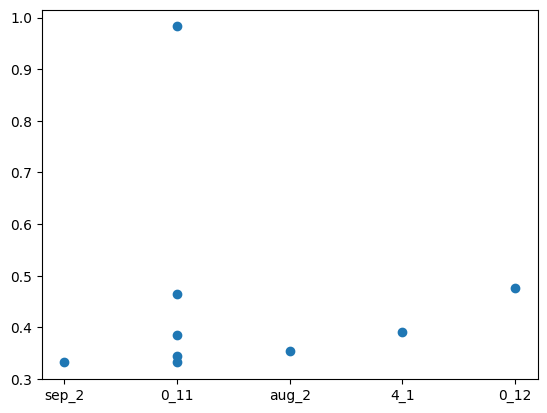

The time of execution of above program is : 65087.130546569824 ms


In [52]:
plt.scatter(x_buffer,y_buffer)
plt.show()
end=time.time()
print("The time of execution of above program is :", (end-start) * 10**3, "ms")